# Feature Extraction from Booking.com Reviews

#### Note: Some of the codes have been optimized using Chatgpt, especially the graphs to get required outputs 

In [1]:
import numpy as np
import pandas as pd
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
import string
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\keval\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:

# Path of the Excel file
file_path = r"C:\Users\keval\Downloads\BookingDotCom_HotelReviews.xlsx"

# Read the Excel file
df = pd.read_excel(file_path)

# Display the first few rows of the dataframe
print(df.head())


    Hotel_Name                                      Hotel_Address  \
0  Hotel Arena   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
1  Hotel Arena   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
2  Hotel Arena   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
3  Hotel Arena   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
4  Hotel Arena   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   

   Review_Count  Non_Review_Scoring_Count  Average_Hotel_Score Review_Date  \
0          1403                       194                  7.7  2017-08-03   
1          1403                       194                  7.7  2017-08-03   
2          1403                       194                  7.7  2017-07-31   
3          1403                       194                  7.7  2017-07-31   
4          1403                       194                  7.7  2017-07-24   

  Reviewer_Nationality                                  Positive_Comments  \
0              Russia    Only the park 

# Question 1
### What are the top five hotel features (e.g., location, staff, etc.) that customers mention the most in positive reviews and top five features they mention most in negative reviews? Your identified features must make sense (e.g., "great" or "negative" are not features).

# Approach 1

#### Clean the text: lowercase, remove punctuation, remove stopwords


In [3]:
def clean_text(text):
    stop_words = set(stopwords.words('english'))
    
    # Convert the input to string if it's not already
    text = str(text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    return text


#### Apply cleaning to both columns

In [4]:
df['Clean_Positive_Comments'] = df['Positive_Comments'].fillna('').apply(clean_text)
df['Clean_Negative_Comments'] = df['Negative_Comments'].fillna('').apply(clean_text)

#### List of words that are not actual features (e.g., adjectives or general words)


In [5]:
non_feature_words = ['good', 'bad', 'negative', 'positive', 'great', 'nice', 'excellent', 'poor','hotel','small',
                     'friendly','helpful','clean']


### Function to extract top features (most common words)

In [6]:
# Function to extract top features, filtering out non-feature words
def get_top_features(text_data, n=5):
    vectorizer = CountVectorizer(max_features=100, stop_words='english')
    X = vectorizer.fit_transform(text_data)
    word_counts = X.sum(axis=0).A1
    word_freq = dict(zip(vectorizer.get_feature_names_out(), word_counts))
    
    # Filter out the non-feature words
    filtered_word_freq = {word: count for word, count in word_freq.items() if word not in non_feature_words}
    
    return sorted(filtered_word_freq.items(), key=lambda x: x[1], reverse=True)[:n]

In [7]:
# Get top 5 features from positive and negative comments
top_positive_features = get_top_features(df['Clean_Positive_Comments'])
top_negative_features = get_top_features(df['Clean_Negative_Comments'])

#### Results

In [8]:

print("Top 5 Positive Features:")
print(top_positive_features)

print("Top 5 Negative Features:")
print(top_negative_features)

Top 5 Positive Features:
[('staff', 194574), ('location', 192856), ('room', 140746), ('breakfast', 84581), ('comfortable', 59952)]
Top 5 Negative Features:
[('room', 176026), ('breakfast', 58478), ('staff', 39512), ('rooms', 34802), ('bed', 29828)]


#### The problem with Approach 1 is that it uses too many vague adjectives, which don't provide clear information about the specific features of the hotels. For example, the 5th positive feature is described as "comfortable," it could refer to anything like the blanket, chair, or another aspect, making it difficult to gain meaningful insights into what exactly is being praised.

# Approach 2: Using Bigrams

In [9]:

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to lemmatize and filter adjectives + nouns in correct order
def lemmatize_and_filter_bigrams(text):
    stop_words = set(stopwords.words('english'))
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)  # Get POS tags
    lemmatized_tokens = []
    
    for word, tag in pos_tags:
        # Only lemmatize adjectives (JJ) and nouns (NN, NNS)
        if tag.startswith('J') or tag.startswith('N'):
            lemma = lemmatizer.lemmatize(word.lower())
            if lemma not in stop_words:
                lemmatized_tokens.append((lemma, tag))  # Keep both the word and its POS tag
    
    # Rebuild text with adjectives before nouns
    cleaned_text = []
    for i in range(len(lemmatized_tokens) - 1):
        word1, tag1 = lemmatized_tokens[i]
        word2, tag2 = lemmatized_tokens[i+1]
        if tag1.startswith('J') and tag2.startswith('N'):  # Adjective followed by a noun
            cleaned_text.append(f"{word1} {word2}")
    
    return ' '.join(cleaned_text)

# Apply the function to both positive and negative comments
df['Lemmatized_Positive_Comments'] = df['Positive_Comments'].fillna('').apply(lambda x: lemmatize_and_filter_bigrams(str(x)))
df['Lemmatized_Negative_Comments'] = df['Negative_Comments'].fillna('').apply(lambda x: lemmatize_and_filter_bigrams(str(x)))

# Function to extract top bigrams
def get_top_bigrams(text_data, n=5):
    vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
    X = vectorizer.fit_transform(text_data)
    bigram_counts = X.sum(axis=0).A1
    bigram_freq = dict(zip(vectorizer.get_feature_names_out(), bigram_counts))
    
    return sorted(bigram_freq.items(), key=lambda x: x[1], reverse=True)

# Function to merge similar pairs (e.g., 'small room' and 'room small')
def merge_similar_pairs(bigrams, top_n=5):
    merged_bigrams = []
    used_words = set()
    
    for bigram, count in bigrams:
        words = set(bigram.split())  # Split the bigram into words
        if not words.intersection(used_words):  # Check if either word has been used
            merged_bigrams.append((bigram, count))
            used_words.update(words)  # Mark the words as used
        if len(merged_bigrams) >= top_n:
            break
    
    return merged_bigrams

# Get top bigrams from lemmatized positive and negative comments
top_positive_bigrams = get_top_bigrams(df['Lemmatized_Positive_Comments'])
top_negative_bigrams = get_top_bigrams(df['Lemmatized_Negative_Comments'])

# Merge similar pairs and get top 5
top_positive_pairs = merge_similar_pairs(top_positive_bigrams)
top_negative_pairs = merge_similar_pairs(top_negative_bigrams)

# Display results
print("Top 5 Positive Feature-Adjective Pairs:")
print(top_positive_pairs)

print("Top 5 Negative Feature-Adjective Pairs:")
print(top_negative_pairs)


Top 5 Positive Feature-Adjective Pairs:
[('friendly staff', 23731), ('good location', 17855), ('comfortable bed', 9937), ('clean room', 6179), ('nice hotel', 3153)]
Top 5 Negative Feature-Adjective Pairs:
[('small room', 6921), ('double bed', 2734), ('little bit', 2621), ('hot water', 1913), ('free wifi', 1457)]


### Approach 2 provides better insights into the hotel features, though there are some vague terms, like "nice hotel" or slightly negative phrases like "little bit", that need to be manually filtered out for more accuracy. 

In [10]:
# List of irrelevant feature-adjective pairs to exclude
irrelevant_pairs = ['little bit', 'nice hotel']

# Updated merge_similar_pairs function to exclude irrelevant pairs
def merge_similar_pairs(bigrams, top_n=5):
    merged_bigrams = []
    used_words = set()
    
    for bigram, count in bigrams:
        words = set(bigram.split())  # Split the bigram into words
        if not words.intersection(used_words) and bigram not in irrelevant_pairs:  # Check if either word has been used or if the bigram is irrelevant
            merged_bigrams.append((bigram, count))
            used_words.update(words)  # Mark the words as used
        if len(merged_bigrams) >= top_n:
            break
    
    return merged_bigrams

# Apply the same process as before
top_positive_bigrams = get_top_bigrams(df['Lemmatized_Positive_Comments'])
top_negative_bigrams = get_top_bigrams(df['Lemmatized_Negative_Comments'])

# Get top bigrams, excluding irrelevant ones
top_positive_pairs = merge_similar_pairs(top_positive_bigrams)
top_negative_pairs = merge_similar_pairs(top_negative_bigrams)

# Display results
print("Top 5 Positive Feature-Adjective Pairs:")
print(top_positive_pairs)

print("Top 5 Negative Feature-Adjective Pairs:")
print(top_negative_pairs)


Top 5 Positive Feature-Adjective Pairs:
[('friendly staff', 23731), ('good location', 17855), ('comfortable bed', 9937), ('clean room', 6179), ('excellent breakfast', 2877)]
Top 5 Negative Feature-Adjective Pairs:
[('small room', 6921), ('double bed', 2734), ('hot water', 1913), ('free wifi', 1457), ('long time', 1129)]


### Answer 1: 
### The top 5 positive features frequently mentioned in customer reviews are the staff, location, bed, room, and breakfast. 
### The top 5 negative features highlighted in reviews include small rooms, issues with double beds, problems with hot water, complaints about free Wi-Fi, and possibly long wait times.

# Question 2
### What are the top five features that customers prefer most if they are a solo traveler vs traveling with a group vs on a business trip vs a leisure trip vs traveling as a couple vs a family with young children. You will find these categories in the "Tags" column. There are a few more tags that we don't need. 

### Removing irrelevant feature-adjective pairs to exclude

In [11]:
# List of irrelevant feature-adjective pairs to exclude
irrelevant_pairs = ['great hotel', 'nice hotel', 'good place', 'great place', 'little bit']


In [12]:
# Relevant tags we want to focus on
relevant_tags = ['Solo traveler', 'Group', 'Business trip', 'Leisure trip', 'Couple', 'Family with young children']


In [13]:
# Function to filter reviews by tag
def filter_reviews_by_tag(tag):
    return df[df['Tags'].str.contains(tag, na=False)]

In [14]:
# Updated merge_similar_pairs function to exclude irrelevant pairs
def merge_similar_pairs(bigrams, top_n=5):
    merged_bigrams = []
    used_words = set()
    
    for bigram, count in bigrams:
        words = set(bigram.split())  # Split the bigram into words
        if not words.intersection(used_words) and bigram not in irrelevant_pairs:  # Check if either word has been used or if the bigram is irrelevant
            merged_bigrams.append((bigram, count))
            used_words.update(words)  # Mark the words as used
        if len(merged_bigrams) >= top_n:
            break
    
    return merged_bigrams

# Function to extract top bigrams for a specific travel category
def get_top_bigrams_for_category(tag, n=5):
    filtered_reviews = filter_reviews_by_tag(tag)
    
    # Get top bigrams from positive comments
    top_positive_bigrams = get_top_bigrams(filtered_reviews['Lemmatized_Positive_Comments'])
    # Get top bigrams from negative comments
    top_negative_bigrams = get_top_bigrams(filtered_reviews['Lemmatized_Negative_Comments'])
    
    # Merge similar bigrams and get the top 5, excluding irrelevant pairs
    top_positive_pairs = merge_similar_pairs(top_positive_bigrams, top_n=n)
    top_negative_pairs = merge_similar_pairs(top_negative_bigrams, top_n=n)
    
    return top_positive_pairs, top_negative_pairs

# Now we can extract top features for each travel category
travel_preferences = {}

for tag in relevant_tags:
    top_positive, top_negative = get_top_bigrams_for_category(tag)
    travel_preferences[tag] = {
        'Top Positive Feature-Adjective Pairs': top_positive,
        'Top Negative Feature-Adjective Pairs': top_negative
    }

# Display the results for each travel category
for tag, features in travel_preferences.items():
    print(f"Top 5 Features for {tag}:")
    print("Top Positive Feature-Adjective Pairs:", features['Top Positive Feature-Adjective Pairs'])
    print("Top Negative Feature-Adjective Pairs:", features['Top Negative Feature-Adjective Pairs'])
    print("\n")


Top 5 Features for Solo traveler:
Top Positive Feature-Adjective Pairs: [('friendly staff', 5014), ('good location', 3960), ('comfortable bed', 2029), ('clean room', 1368), ('easy access', 525)]
Top Negative Feature-Adjective Pairs: [('small room', 1997), ('hot water', 493), ('free wifi', 399), ('double bed', 369), ('long time', 250)]


Top 5 Features for Group:
Top Positive Feature-Adjective Pairs: [('friendly staff', 2959), ('good location', 2197), ('comfortable bed', 1323), ('clean room', 809), ('hotel great', 376)]
Top Negative Feature-Adjective Pairs: [('small room', 703), ('double bed', 348), ('hot water', 219), ('free wifi', 184), ('long time', 154)]


Top 5 Features for Business trip:
Top Positive Feature-Adjective Pairs: [('friendly staff', 3668), ('good location', 3206), ('comfortable bed', 1434), ('clean room', 966), ('great breakfast', 408)]
Top Negative Feature-Adjective Pairs: [('small room', 1632), ('hot water', 383), ('double bed', 318), ('free wifi', 313), ('long time'

# Visualization for better understanding of the output

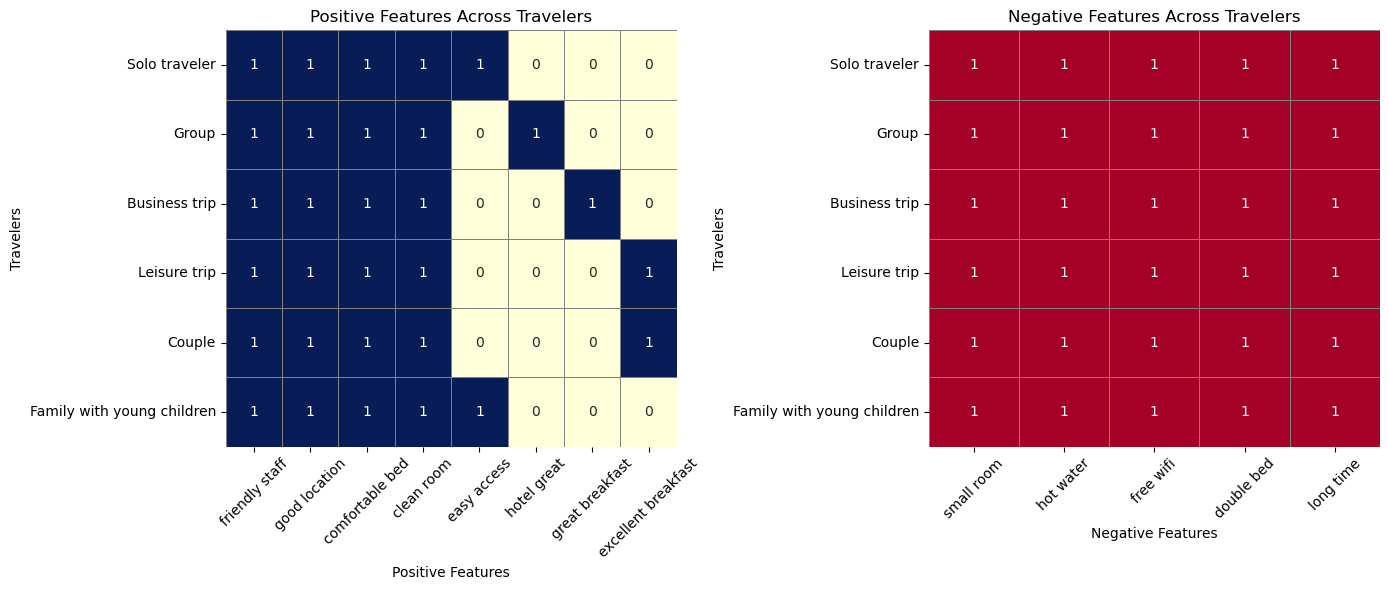

In [15]:
# Initialize dictionaries to track feature occurrences
positive_feature_occurrence = {}
negative_feature_occurrence = {}

# Extract features for the matrices
for country, features in travel_preferences.items():
    # Get positive features
    positive_features = [pair[0] for pair in features['Top Positive Feature-Adjective Pairs']]
    
    # Get negative features
    negative_features = [pair[0] for pair in features['Top Negative Feature-Adjective Pairs']]
    
    # Populate the positive occurrence dictionary
    for feature in positive_features:
        if feature not in positive_feature_occurrence:
            positive_feature_occurrence[feature] = [0] * len(travel_preferences)  # Initialize with zeros
        positive_feature_occurrence[feature][list(travel_preferences.keys()).index(country)] = 1  # Mark presence with 1

    # Populate the negative occurrence dictionary
    for feature in negative_features:
        if feature not in negative_feature_occurrence:
            negative_feature_occurrence[feature] = [0] * len(travel_preferences)  # Initialize with zeros
        negative_feature_occurrence[feature][list(travel_preferences.keys()).index(country)] = 1  # Mark presence with 1

# Convert the positive and negative occurrence dictionaries into DataFrames
positive_feature_matrix = pd.DataFrame(positive_feature_occurrence, index=travel_preferences.keys()).fillna(0)
negative_feature_matrix = pd.DataFrame(negative_feature_occurrence, index=travel_preferences.keys()).fillna(0)

# Step 2: Create heatmaps using seaborn
plt.figure(figsize=(14, 6))

# Positive Features Heatmap
plt.subplot(1, 2, 1)
sns.heatmap(positive_feature_matrix, annot=True, cmap='YlGnBu', cbar=False, linewidths=.5, linecolor='gray', fmt='g')
plt.title('Positive Features Across Travelers')
plt.xlabel('Positive Features')
plt.ylabel('Travelers')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Negative Features Heatmap
plt.subplot(1, 2, 2)
sns.heatmap(negative_feature_matrix, annot=True, cmap='RdYlBu', cbar=False, linewidths=.5, linecolor='gray', fmt='g')
plt.title('Negative Features Across Travelers')
plt.xlabel('Negative Features')
plt.ylabel('Travelers')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

### It's intriguing to note that the top five positive features varied significantly among different types of travelers—such as solo travelers, those traveling in groups, business travelers, leisure travelers, couples, and families with young children. However, the issues they encountered were quite similar across these groups, albeit in different order. Ultimately, all travelers desired solutions to the same five key concerns.

# Question 3
### What are the top five features customers like most and top five features they complain about most about hotels in United Kingdom, France, Italy, and Spain? Country information is available inside Hotel_Address. 

In [16]:
# List of relevant countries we want to analyze
relevant_countries = ['United Kingdom', 'France', 'Italy', 'Spain']

In [17]:
# Function to extract country name from Hotel_Address
def extract_country(address):
    for country in relevant_countries:
        if country in address:
            return country
    return None

In [18]:
# Add a new column 'Country' to the dataframe based on Hotel_Address
df['Country'] = df['Hotel_Address'].apply(extract_country)

# Function to filter reviews by country
def filter_reviews_by_country(country):
    return df[df['Country'] == country]


In [19]:
# List of irrelevant feature-adjective pairs to exclude
irrelevant_pairs = ['great hotel', 'nice hotel', 'good place', 'great place', 'little bit']

# Updated merge_similar_pairs function to exclude irrelevant pairs
def merge_similar_pairs(bigrams, top_n=5):
    merged_bigrams = []
    used_words = set()
    
    for bigram, count in bigrams:
        words = set(bigram.split())  # Split the bigram into words
        if not words.intersection(used_words) and bigram not in irrelevant_pairs:  # Check if either word has been used or if the bigram is irrelevant
            merged_bigrams.append((bigram, count))
            used_words.update(words)  # Mark the words as used
        if len(merged_bigrams) >= top_n:
            break
    
    return merged_bigrams

# Function to extract top bigrams for a specific country
def get_top_bigrams_for_country(country, n=5):
    filtered_reviews = filter_reviews_by_country(country)
    
    # Get top bigrams from positive comments
    top_positive_bigrams = get_top_bigrams(filtered_reviews['Lemmatized_Positive_Comments'])
    # Get top bigrams from negative comments
    top_negative_bigrams = get_top_bigrams(filtered_reviews['Lemmatized_Negative_Comments'])
    
    # Merge similar bigrams and get the top 5, excluding irrelevant pairs
    top_positive_pairs = merge_similar_pairs(top_positive_bigrams, top_n=n)
    top_negative_pairs = merge_similar_pairs(top_negative_bigrams, top_n=n)
    
    return top_positive_pairs, top_negative_pairs

# Extract top features for each country
country_preferences = {}

for country in relevant_countries:
    top_positive, top_negative = get_top_bigrams_for_country(country)
    country_preferences[country] = {
        'Top Positive Feature-Adjective Pairs': top_positive,
        'Top Negative Feature-Adjective Pairs': top_negative
    }

# Display the results for each country
for country, features in country_preferences.items():
    print(f"Top 5 Features for {country}:")
    print("Top Positive Feature-Adjective Pairs:", features['Top Positive Feature-Adjective Pairs'])
    print("Top Negative Feature-Adjective Pairs:", features['Top Negative Feature-Adjective Pairs'])
    print("\n")


Top 5 Features for United Kingdom:
Top Positive Feature-Adjective Pairs: [('friendly staff', 11771), ('good location', 8437), ('comfortable bed', 5107), ('clean room', 2733), ('central london', 1933)]
Top Negative Feature-Adjective Pairs: [('small room', 4167), ('double bed', 1409), ('hot water', 1128), ('free wifi', 876), ('long time', 648)]


Top 5 Features for France:
Top Positive Feature-Adjective Pairs: [('friendly staff', 2863), ('good location', 2256), ('comfortable bed', 1150), ('clean room', 711), ('hotel great', 391)]
Top Negative Feature-Adjective Pairs: [('small room', 1216), ('hot water', 207), ('double bed', 187), ('expensive breakfast', 118), ('early morning', 111)]


Top 5 Features for Italy:
Top Positive Feature-Adjective Pairs: [('friendly staff', 1548), ('good location', 1444), ('comfortable bed', 661), ('clean room', 609), ('central station', 533)]
Top Negative Feature-Adjective Pairs: [('small room', 319), ('hot water', 139), ('double bed', 97), ('long time', 83), 

# Visualization

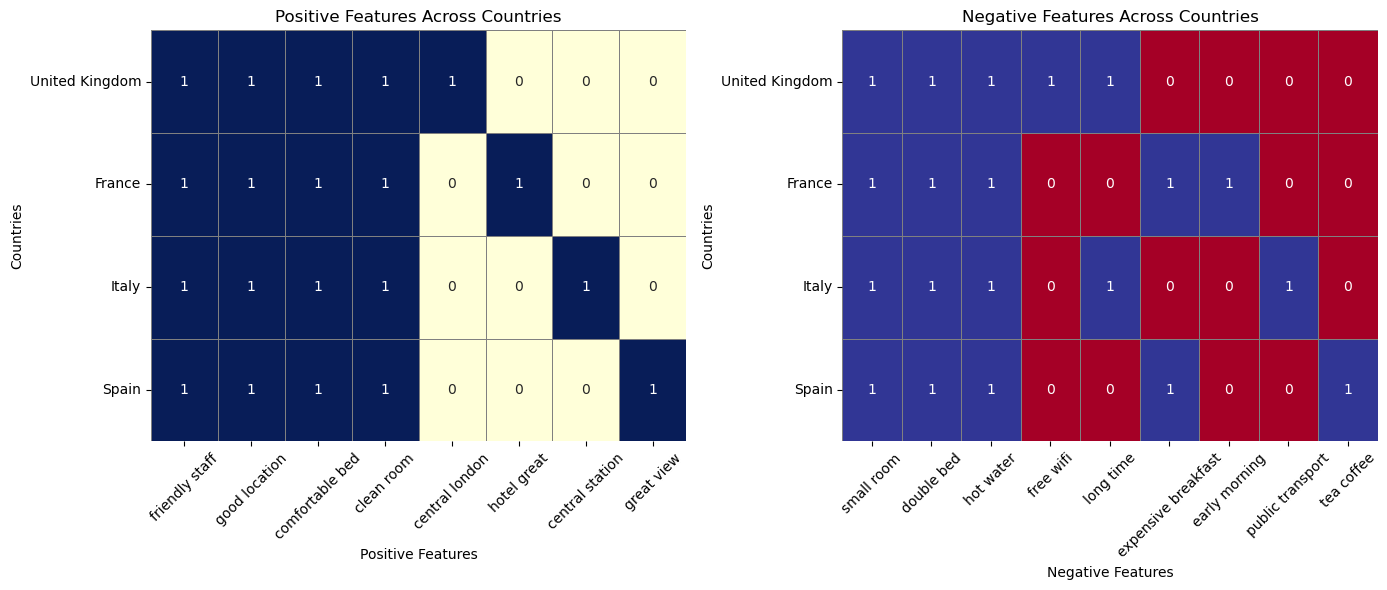

In [20]:
# Initialize dictionaries to track feature occurrences
positive_feature_occurrence = {}
negative_feature_occurrence = {}

# Extract features for the matrices
for country, features in country_preferences.items():
    # Get positive features
    positive_features = [pair[0] for pair in features['Top Positive Feature-Adjective Pairs']]
    
    # Get negative features
    negative_features = [pair[0] for pair in features['Top Negative Feature-Adjective Pairs']]
    
    # Populate the positive occurrence dictionary
    for feature in positive_features:
        if feature not in positive_feature_occurrence:
            positive_feature_occurrence[feature] = [0] * len(country_preferences)  # Initialize with zeros
        positive_feature_occurrence[feature][list(country_preferences.keys()).index(country)] = 1  # Mark presence with 1

    # Populate the negative occurrence dictionary
    for feature in negative_features:
        if feature not in negative_feature_occurrence:
            negative_feature_occurrence[feature] = [0] * len(country_preferences)  # Initialize with zeros
        negative_feature_occurrence[feature][list(country_preferences.keys()).index(country)] = 1  # Mark presence with 1

# Convert the positive and negative occurrence dictionaries into DataFrames
positive_feature_matrix = pd.DataFrame(positive_feature_occurrence, index=country_preferences.keys()).fillna(0)
negative_feature_matrix = pd.DataFrame(negative_feature_occurrence, index=country_preferences.keys()).fillna(0)

# Step 2: Create heatmaps using seaborn
plt.figure(figsize=(14, 6))

# Positive Features Heatmap
plt.subplot(1, 2, 1)
sns.heatmap(positive_feature_matrix, annot=True, cmap='YlGnBu', cbar=False, linewidths=.5, linecolor='gray', fmt='g')
plt.title('Positive Features Across Countries')
plt.xlabel('Positive Features')
plt.ylabel('Countries')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Negative Features Heatmap
plt.subplot(1, 2, 2)
sns.heatmap(negative_feature_matrix, annot=True, cmap='RdYlBu', cbar=False, linewidths=.5, linecolor='gray', fmt='g')
plt.title('Negative Features Across Countries')
plt.xlabel('Negative Features')
plt.ylabel('Countries')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

### Analysis of the top five features across these countries reveals that customers consistently appreciate four key elements: staff, location, bed quality, and cleanliness. Conversely, when it comes to complaints, three issues are commonly cited: small room sizes, problems with double beds, and hot water availability.

# Question 4

### Create a dashboard with the following plots; (1) "Top Five Hotels Overall" with consistently high ratings, (2) Bottom Five Hotels Overall" with consistently low ratings, (3) Five Most Improved Hotels" with the highest improvement in average ratings from 2015 to 2017, showing their average ratings for each of the three years.

In [21]:
# Convert 'Review_Date' to datetime format
df['Review_Date'] = pd.to_datetime(df['Review_Date'])
df['Year'] = df['Review_Date'].dt.year

# Filter data for the years 2015, 2016, and 2017
df_filtered = df[df['Year'].isin([2015, 2016, 2017])]

# Calculate overall average reviewer score for each hotel
hotel_avg_scores = df.groupby('Hotel_Name')['Reviewer_Score'].mean().reset_index()

# (1) Top Five Hotels Overall
top_5_hotels = hotel_avg_scores.nlargest(5, 'Reviewer_Score')

# (2) Bottom Five Hotels Overall
bottom_5_hotels = hotel_avg_scores.nsmallest(5, 'Reviewer_Score')

# Calculate yearly average reviewer scores per hotel
yearly_avg_scores = df_filtered.groupby(['Hotel_Name', 'Year'])['Reviewer_Score'].mean().reset_index()

# Pivot to have years as columns
hotel_yearly_scores = yearly_avg_scores.pivot(index='Hotel_Name', columns='Year', values='Reviewer_Score').reset_index()

# Calculate improvement between 2015 and 2017
hotel_yearly_scores['Improvement'] = hotel_yearly_scores[2017] - hotel_yearly_scores[2015]

# (3) Five Most Improved Hotels
most_improved_hotels = hotel_yearly_scores.nlargest(5, 'Improvement')



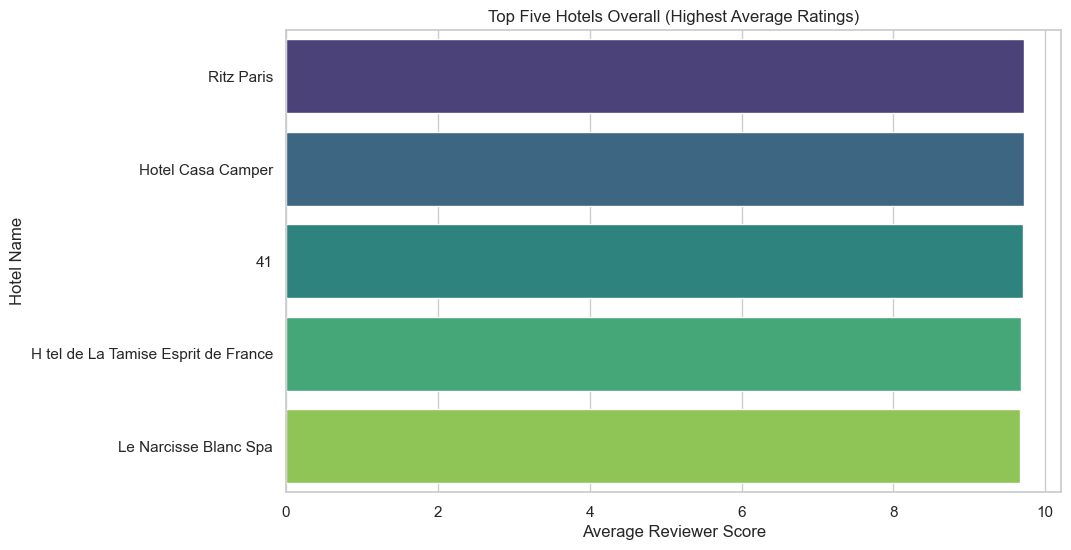

In [22]:
# --- Plotting ---

# Set Seaborn style
sns.set(style="whitegrid")

# (1) Top Five Hotels Overall
plt.figure(figsize=(10, 6))
sns.barplot(x='Reviewer_Score', y='Hotel_Name', data=top_5_hotels, palette='viridis')
plt.title('Top Five Hotels Overall (Highest Average Ratings)')
plt.xlabel('Average Reviewer Score')
plt.ylabel('Hotel Name')
plt.show()



#### Hotel name 41 seems bit skeptical, so we will check that in our data

In [23]:
filtered_df = df[df['Hotel_Name'] == 41]


In [24]:
filtered_df.head()

,Hotel_Name,Hotel_Address,Review_Count,Non_Review_Scoring_Count,Average_Hotel_Score,Review_Date,Reviewer_Nationality,Positive_Comments,Negative_Comments,Total_Reviewer_Reviews,Reviewer_Score,Tags,Clean_Positive_Comments,Clean_Negative_Comments,Lemmatized_Positive_Comments,Lemmatized_Negative_Comments,Country,Year
185602,41,41 Buckingham Palace Road Westminster Borough ...,244,66,9.6,2017-06-18,Australia,Its central proximity close to all services a...,There wasn t a thing that we didn t like,8,10.0,"[' Leisure trip ', ' Couple ', ' Executive Kin...",central proximity close services restaurants s...,thing like,central proximity best world complimentary tre...,,United Kingdom,2017
185603,41,41 Buckingham Palace Road Westminster Borough ...,244,66,9.6,2017-06-04,Hong Kong,Great location walking distance to many touri...,No Negative,5,9.2,"[' Leisure trip ', ' Group ', ' Executive King...",great location walking distance many tourist s...,negative,tourist spot helpful discreet spacious london ...,,United Kingdom,2017
185604,41,41 Buckingham Palace Road Westminster Borough ...,244,66,9.6,2017-06-01,United States of America,Excellent location Attentive courteous staff,Details of room Hard to get to plugs shower i...,18,7.9,"[' Leisure trip ', ' Group ', ' Executive King...",excellent location attentive courteous staff,details room hard get plugs shower like flood ...,excellent location courteous staff,old move old blow le hotel small hotel 5th flo...,United Kingdom,2017
185605,41,41 Buckingham Palace Road Westminster Borough ...,244,66,9.6,2017-05-25,United Kingdom,Amazing attention to detail Our stay was made...,Minimal wifi in the bedroom,13,10.0,"[' Leisure trip ', ' Couple ', ' Executive Kin...",amazing attention detail stay made special foo...,minimal wifi bedroom,special food full staff,minimal wifi,United Kingdom,2017
185606,41,41 Buckingham Palace Road Westminster Borough ...,244,66,9.6,2017-03-13,,It was perfectly set up for business or pleas...,No Negative,1,10.0,"[' Business trip ', ' Group ', ' Executive Kin...",perfectly set business pleasure staff superb h...,negative,helpful resourceful friendly everyone,,United Kingdom,2017


In [25]:
filtered_df.shape 


(103, 18)

#### So 41 seems to be legitimate hotel name 

### Bottom Five Hotels Overall

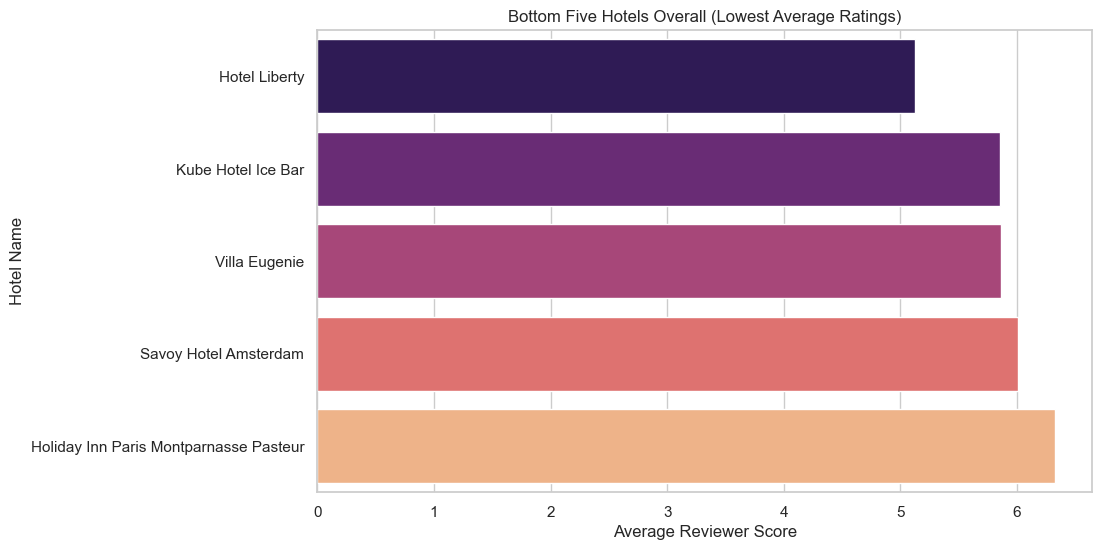

In [26]:
# (2) Bottom Five Hotels Overall
plt.figure(figsize=(10, 6))
sns.barplot(x='Reviewer_Score', y='Hotel_Name', data=bottom_5_hotels, palette='magma')
plt.title('Bottom Five Hotels Overall (Lowest Average Ratings)')
plt.xlabel('Average Reviewer Score')
plt.ylabel('Hotel Name')
plt.show()



### Five Most Improved Hotels (2015 to 2017)

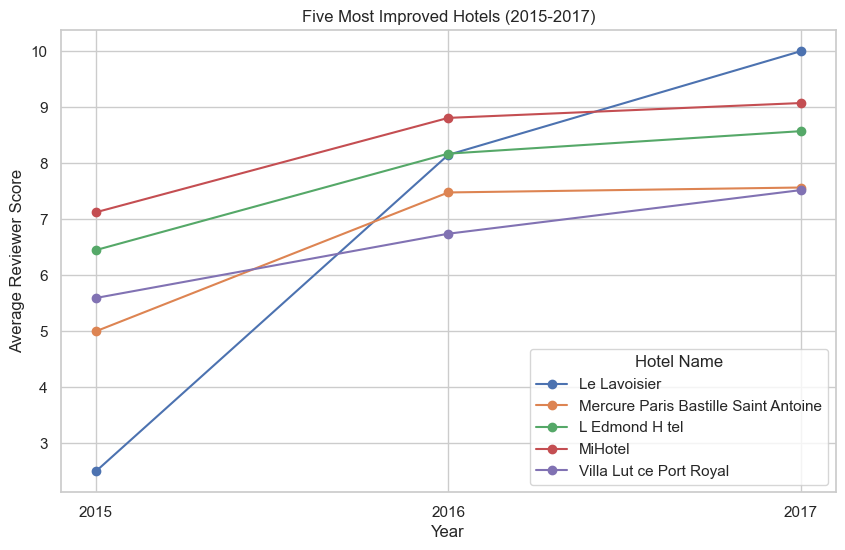

In [27]:
# (3) Five Most Improved Hotels (2015 to 2017)
plt.figure(figsize=(10, 6))
for i, row in most_improved_hotels.iterrows():
    plt.plot([2015, 2016, 2017], [row[2015], row[2016], row[2017]], marker='o', label=row['Hotel_Name'])

plt.title('Five Most Improved Hotels (2015-2017)')
plt.xlabel('Year')
plt.ylabel('Average Reviewer Score')
plt.xticks([2015, 2016, 2017])
plt.legend(title='Hotel Name')
plt.show()


### The overall trend indicates improvements in the reviewer scores for all the listed hotels from 2015 to 2017, suggesting enhancements in service, amenities, or overall guest satisfaction during this period.
#### Le Lavoisier
#### Mercure Paris Bastille Saint Antoine
#### L Edmond H tel
#### MiHotel
#### Villa Lut ce Port Royal